In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import pandas as pd
import csv
try:
    df = pd.read_csv('job_descriptions.csv')
except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")
    # Attempt to read with error handling
    try:
        # Skip bad lines and disable quote processing
        df = pd.read_csv('job_descriptions.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
        print("CSV loaded with error handling. Some data may be skipped.")
    except pd.errors.ParserError as e2:
        print(f"Another error occurred: {e2}")

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20403 entries, 0 to 20402
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Job Id            20403 non-null  int64  
 1   Experience        20403 non-null  object 
 2   Qualifications    20403 non-null  object 
 3   Salary Range      20403 non-null  object 
 4   location          20403 non-null  object 
 5   Country           20403 non-null  object 
 6   latitude          20403 non-null  float64
 7   longitude         20403 non-null  float64
 8   Work Type         20403 non-null  object 
 9   Company Size      20403 non-null  int64  
 10  Job Posting Date  20403 non-null  object 
 11  Preference        20403 non-null  object 
 12  Contact Person    20403 non-null  object 
 13  Contact           20403 non-null  object 
 14  Job Title         20403 non-null  object 
 15  Role              20403 non-null  object 
 16  Job Portal        20403 non-null  object

In [4]:
# Fill missing text values with 'Unknown'
text_cols = ['Company Profile', 'skills', 'Job Description', 'Benefits', 'Responsibilities']
df[text_cols] = df[text_cols].fillna('Unknown')

# Fill missing numerical columns with 0 or median (as appropriate)
df[['latitude', 'longitude', 'Company Size']] = df[['latitude', 'longitude', 'Company Size']].fillna(0)

# Fill categorical columns with mode
categorical_cols = ['Work Type', 'Preference', 'Role', 'Job Title']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [5]:
if 'Salary Range' in df.columns:
    df['Salary Range'] = df['Salary Range'].str.replace(r'[^\d\-\sK]', '', regex=True)  # Remove non-numeric characters
    df['Salary Range'] = df['Salary Range'].str.replace('K', '000')  # Replace 'K' with '000'
    salary_split = df['Salary Range'].str.split('-', expand=True).fillna('0')
    df['Min Salary'] = pd.to_numeric(salary_split[0], errors='coerce').fillna(0)
    df['Max Salary'] = pd.to_numeric(salary_split[1], errors='coerce').fillna(0)
    df = df.drop('Salary Range', axis=1)


In [6]:
# Extract Min and Max Experience
experience_split = df['Experience'].str.extract(r'(\d+)\s*to\s*(\d+)', expand=True)
df['Min Experience'] = pd.to_numeric(experience_split[0], errors='coerce').fillna(0)
df['Max Experience'] = pd.to_numeric(experience_split[1], errors='coerce').fillna(0)

In [7]:
# Label encode 'Role' and 'location'
label_encoder = LabelEncoder()
df['Role'] = label_encoder.fit_transform(df['Role'].astype(str))
df['location'] = label_encoder.fit_transform(df['location'].astype(str))

# One-hot encode 'Preference'
df = pd.get_dummies(df, columns=['Preference'], drop_first=True)


In [8]:
# Apply TF-IDF Vectorizer on 'skills'
tfidf = TfidfVectorizer(max_features=100)  # Limit to top 100 skills
skills_matrix = tfidf.fit_transform(df['skills']).toarray()

# Add TF-IDF features to the dataset
skills_df = pd.DataFrame(skills_matrix, columns=[f'Skill_{i}' for i in range(skills_matrix.shape[1])])
df = pd.concat([df.reset_index(drop=True), skills_df.reset_index(drop=True)], axis=1)

# Drop the original 'skills' column
df = df.drop('skills', axis=1)

In [10]:
scaler = MinMaxScaler()
numerical_cols = ['Min Salary', 'Max Salary', 'Min Experience', 'Max Experience', 'latitude', 'longitude']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [11]:
# Display the final dataset
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20403 entries, 0 to 20402
Columns: 126 entries, Job Id to Skill_99
dtypes: bool(2), float64(106), int64(4), object(14)
memory usage: 19.3+ MB
None
             Job Id     Experience Qualifications  location           Country  \
0  1089843540111562  5 to 15 Years         M.Tech        59       Isle of Man   
1   398454096642776  2 to 12 Years            BCA        11      Turkmenistan   
2   481640072963533  0 to 12 Years            PhD       102  Macao SAR, China   
3   688192671473044  4 to 11 Years            PhD       152             Benin   
4   117057806156508  1 to 12 Years            MBA       172             Chile   

   latitude  longitude  Work Type  Company Size Job Posting Date  ...  \
0  0.844852   0.483068     Intern         26801       2022-04-24  ...   
1  0.709280   0.664531     Intern        100340       2022-12-19  ...   
2  0.560347   0.817357  Temporary         84525       2022-09-14  ...   
3  0.445870   0.502498  

In [12]:
# Reduce dataset size to 5000 rows
reduced_df = df.sample(n=5000, random_state=42).reset_index(drop=True)
# Verify the reduced dataset
print(reduced_df.info())
print(reduced_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 126 entries, Job Id to Skill_99
dtypes: bool(2), float64(106), int64(4), object(14)
memory usage: 4.7+ MB
None
             Job Id     Experience Qualifications  location     Country  \
0  2040354270186315  2 to 15 Years         M.Tech       113    Eswatini   
1  1105828996231152  5 to 15 Years         M.Tech       114      Mexico   
2  1056499360777741  2 to 13 Years            PhD        15  Azerbaijan   
3   548849874673581   3 to 8 Years             BA        20      Gambia   
4  1468315968579637  0 to 13 Years            PhD        92       Gabon   

   latitude  longitude  Work Type  Company Size Job Posting Date  ...  \
0  0.598744   0.585015  Full-Time         59906       2022-03-24  ...   
1  0.573098   0.205641   Contract        130681       2023-04-29  ...   
2  0.719701   0.630621  Full-Time         26926       2023-06-07  ...   
3  0.482595   0.452603  Part-Time        125679       2021-09-1

In [13]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.4 MB/s eta 0:00:00


In [14]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl


In [15]:
# Define fuzzy input variables
skills_match = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'skills_match')
experience = ctrl.Antecedent(np.arange(0, 11, 1), 'experience')
salary = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'salary')  # Assume normalized salary (0-1)

# Define fuzzy output variable
job_match_score = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'job_match_score')


In [16]:
# Membership functions for 'skills_match'
skills_match['low'] = fuzz.trimf(skills_match.universe, [0, 0, 0.4])
skills_match['medium'] = fuzz.trimf(skills_match.universe, [0.3, 0.5, 0.7])
skills_match['high'] = fuzz.trimf(skills_match.universe, [0.6, 1, 1])

# Membership functions for 'experience'
experience['low'] = fuzz.trimf(experience.universe, [0, 0, 4])
experience['medium'] = fuzz.trimf(experience.universe, [3, 5, 7])
experience['high'] = fuzz.trimf(experience.universe, [6, 10, 10])

# Membership functions for 'salary'
salary['low'] = fuzz.trimf(salary.universe, [0, 0, 0.5])
salary['medium'] = fuzz.trimf(salary.universe, [0.4, 0.6, 0.8])
salary['high'] = fuzz.trimf(salary.universe, [0.7, 1, 1])

# Membership functions for 'job_match_score'
job_match_score['low'] = fuzz.trimf(job_match_score.universe, [0, 0, 0.4])
job_match_score['medium'] = fuzz.trimf(job_match_score.universe, [0.3, 0.6, 0.8])
job_match_score['high'] = fuzz.trimf(job_match_score.universe, [0.7, 1, 1])



In [17]:
# Fuzzy rules for job matching
rule1 = ctrl.Rule(skills_match['high'] & experience['high'] & salary['medium'], job_match_score['high'])
rule2 = ctrl.Rule(skills_match['medium'] & experience['medium'] & salary['medium'], job_match_score['medium'])
rule3 = ctrl.Rule(skills_match['low'] | experience['low'], job_match_score['low'])
rule4 = ctrl.Rule(salary['low'], job_match_score['low'])

# Combine rules into a control system
job_match_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4])


In [18]:
# Create control system simulation
job_match_sim = ctrl.ControlSystemSimulation(job_match_ctrl, flush_after_run=100, clip_to_bounds=True)


In [19]:
def calculate_job_match(row):
    try:
        # Clamp inputs to the valid range
        skills_input = max(0, min(row['Skill_0'], 1))  # Use Skill_0 as a proxy for skills match
        experience_input = max(0, min(row['Min Experience'] * 10, 10))  # Scale experience to match range
        salary_input = max(0, min(row['Min Salary'], 1))  # Assume salary is normalized

        # Set inputs to the fuzzy system
        job_match_sim.input['skills_match'] = skills_input
        job_match_sim.input['experience'] = experience_input
        job_match_sim.input['salary'] = salary_input

        # Compute job match score
        job_match_sim.compute()

        # Return the computed job match score
        return job_match_sim.output['job_match_score']
    except Exception as e:
        print(f"Error processing row {row.name}: {e}")
        return 0.1  # Default low score for unmatched cases


In [22]:

# Apply the function to the dataset
reduced_df['Job Match Score'] = reduced_df.apply(calculate_job_match, axis=1)

# Verify the results
print(reduced_df[['Job Id', 'Job Match Score']].head())


Error processing row 35: 'job_match_score'
Error processing row 168: 'job_match_score'
Error processing row 280: 'job_match_score'
Error processing row 467: 'job_match_score'
Error processing row 1975: 'job_match_score'
Error processing row 2310: 'job_match_score'
Error processing row 2331: 'job_match_score'
Error processing row 2344: 'job_match_score'
Error processing row 2379: 'job_match_score'
Error processing row 2409: 'job_match_score'
Error processing row 2580: 'job_match_score'
Error processing row 2839: 'job_match_score'
Error processing row 3232: 'job_match_score'
Error processing row 3621: 'job_match_score'
Error processing row 3658: 'job_match_score'
Error processing row 4209: 'job_match_score'
Error processing row 4364: 'job_match_score'
Error processing row 4619: 'job_match_score'
Error processing row 4747: 'job_match_score'
Error processing row 4750: 'job_match_score'
             Job Id  Job Match Score
0  2040354270186315         0.319311
1  1105828996231152         0.1

In [23]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [24]:

# Features: Select relevant columns for training
X = reduced_df[['Skill_0', 'Min Experience', 'Min Salary', 'Role', 'location']]  # Add more columns if needed

# Target: Job Match Score
y = reduced_df['Job Match Score']

# Normalize features for better NN performance
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [25]:

# Initialize the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer with 64 neurons
    Dense(32, activation='relu'),  # Hidden layer with 32 neurons
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE for regression


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=16, verbose=1)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0047 - mae: 0.0415 - val_loss: 4.6962e-04 - val_mae: 0.0083
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5504e-04 - mae: 0.0072 - val_loss: 4.1652e-04 - val_mae: 0.0072
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9718e-04 - mae: 0.0073 - val_loss: 4.0905e-04 - val_mae: 0.0053
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5403e-04 - mae: 0.0060 - val_loss: 3.7321e-04 - val_mae: 0.0054
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.9391e-04 - mae: 0.0071 - val_loss: 4.0110e-04 - val_mae: 0.0072
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3801e-04 - mae: 0.0058 - val_loss: 4.2917e-04 - val_mae: 0.0100
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7649e-04 - mae: 0.0060 - val_loss: 5.1461e-04 - val_mae: 0.0109
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2394e-04 - mae: 0.0066 - val_loss: 3.4817e-04 - val_mae: 0.0

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Evaluate on the test data
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")

# Predict job match scores
y_pred = model.predict(X_test)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Summarize evaluation metrics
metrics_summary = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE'],
    'Value': [mae, mse, rmse]
})

# Display metrics summary
print(metrics_summary)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - mae: 0.0080
Mean Absolute Error (MAE) on Test Data: 0.007166961673647165
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Squared Error (MSE): 0.000779409270927792
Root Mean Squared Error (RMSE): 0.02791790233752873
  Metric     Value
0    MAE  0.007167
1    MSE  0.000779
2   RMSE  0.027918


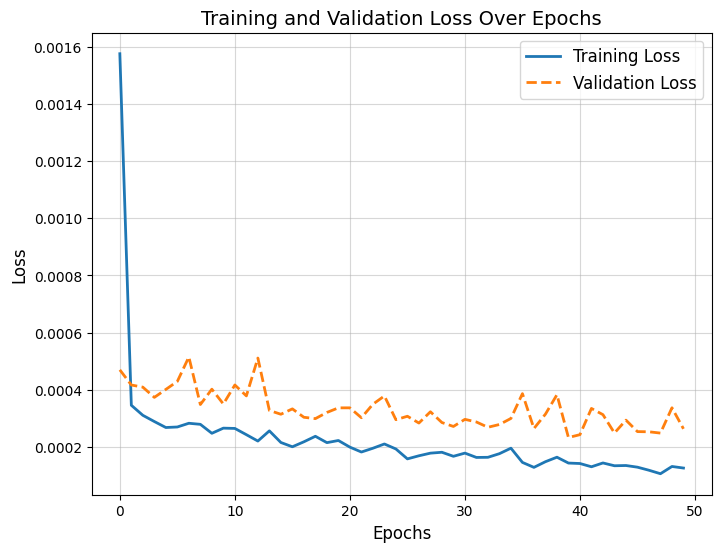

In [28]:
import matplotlib.pyplot as plt

# Training and validation loss visualization
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
plt.title('Training and Validation Loss Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

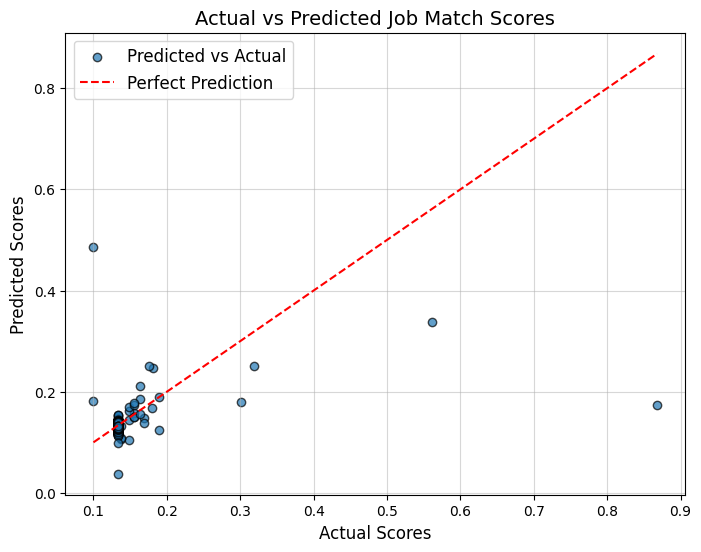

In [29]:
# Scatter plot for Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Job Match Scores', fontsize=14)
plt.xlabel('Actual Scores', fontsize=12)
plt.ylabel('Predicted Scores', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()


                           Metric     Value
0       Mean Absolute Error (MAE)  0.007167
1        Mean Squared Error (MSE)  0.000779
2  Root Mean Squared Error (RMSE)  0.027918


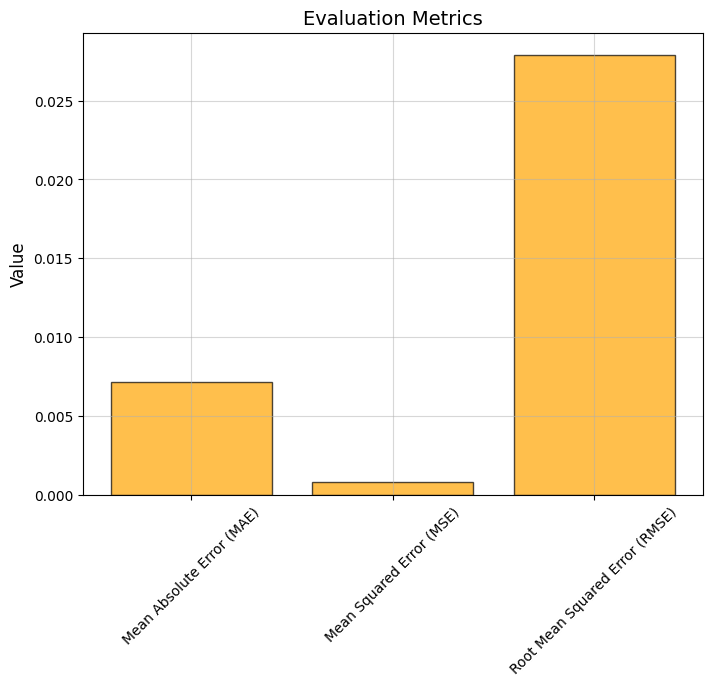

In [31]:
import pandas as pd

# Summarize metrics
metrics_summary = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)'],
    'Value': [mae, mse, rmse]
})

# Display metrics table
print(metrics_summary)

# Optional: Visualize the metrics as a bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics_summary['Metric'], metrics_summary['Value'], color='orange', edgecolor='black', alpha=0.7)
plt.title('Evaluation Metrics', fontsize=14)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(alpha=0.5)
plt.show()


In [58]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print(f"XGBoost Model - MAE: {mae_xgb}, MSE: {mse_xgb}, RMSE: {rmse_xgb}")


XGBoost Model - MAE: 0.002653069047951043, MSE: 0.0008908834414060318, RMSE: 0.029847670619430788


In [59]:
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"Random Forest Model - MAE: {mae_rf}, MSE: {mse_rf}, RMSE: {rmse_rf}")


Random Forest Model - MAE: 0.0025180129046497427, MSE: 0.0007680310379409756, RMSE: 0.02771337290805606


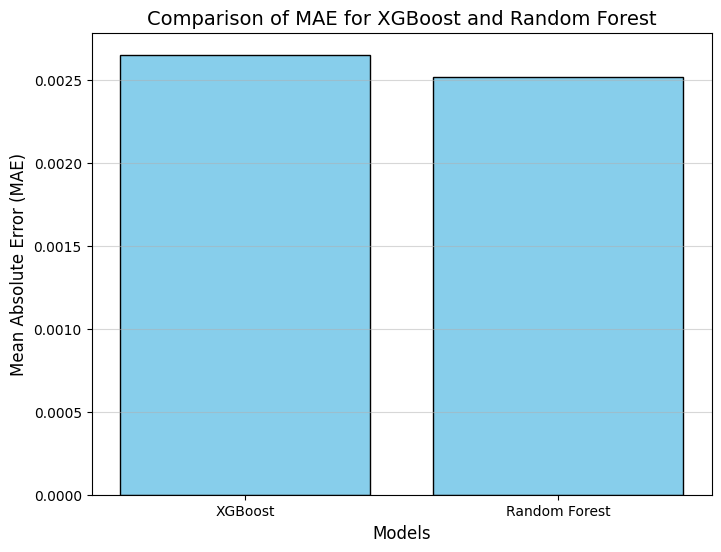

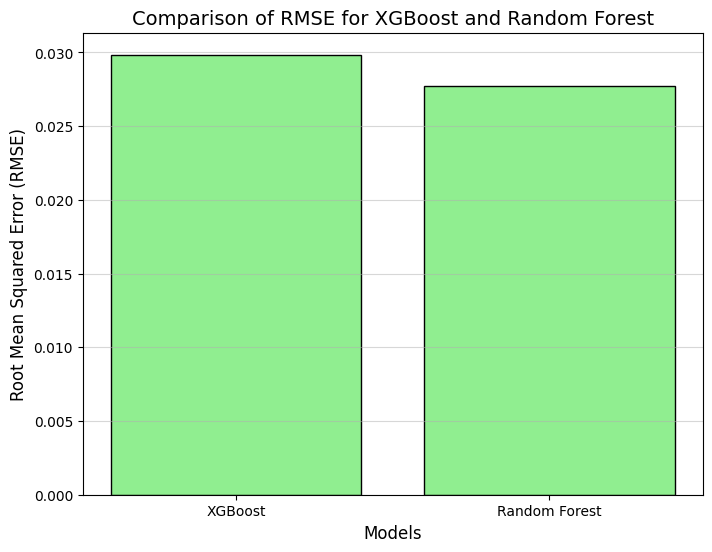

In [60]:
import matplotlib.pyplot as plt

# Collect performance metrics for XGBoost and Random Forest
models = ['XGBoost', 'Random Forest']
mae_scores = [mae_xgb, mae_rf]
rmse_scores = [rmse_xgb, rmse_rf]

# Plot MAE comparison
plt.figure(figsize=(8, 6))
plt.bar(models, mae_scores, color='skyblue', edgecolor='black')
plt.title('Comparison of MAE for XGBoost and Random Forest', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

# Plot RMSE comparison
plt.figure(figsize=(8, 6))
plt.bar(models, rmse_scores, color='lightgreen', edgecolor='black')
plt.title('Comparison of RMSE for XGBoost and Random Forest', fontsize=14)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()


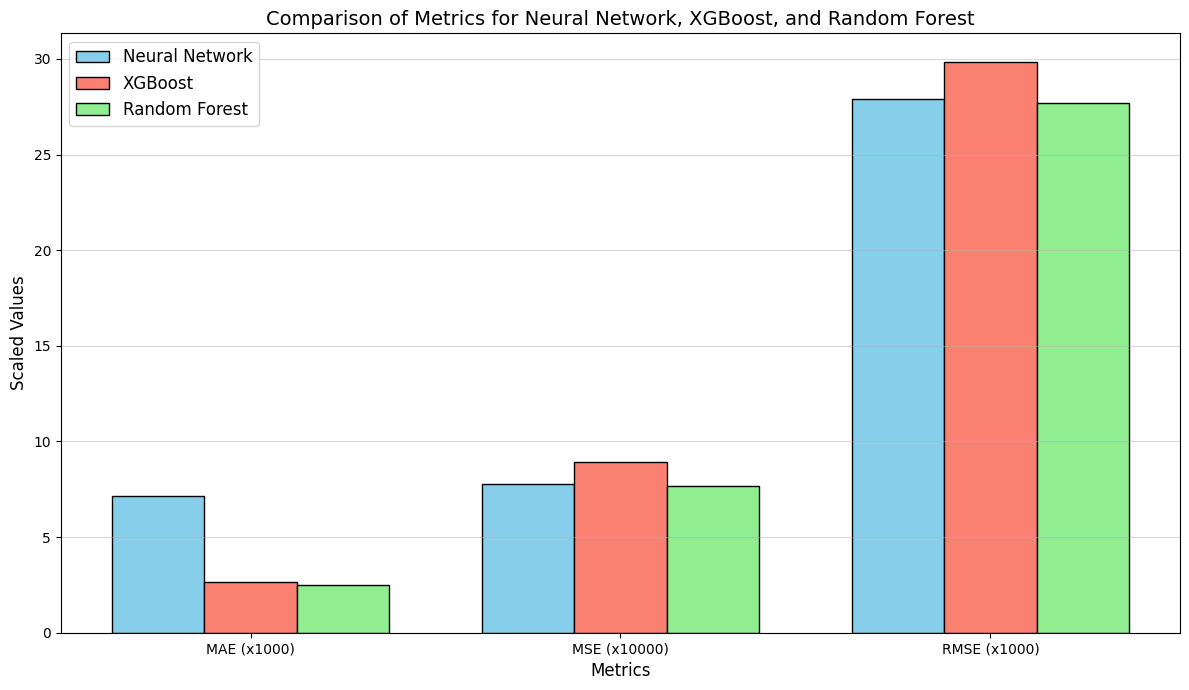

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics for comparison
metrics = ['MAE (x1000)', 'MSE (x10000)', 'RMSE (x1000)']
nn_values = [0.007167 * 1000, 0.000779 * 10000, 0.027918 * 1000]  # Neural Network metrics
xgb_values = [0.002653 * 1000, 0.000891 * 10000, 0.029848 * 1000]  # XGBoost metrics
rf_values = [0.002518 * 1000, 0.000768 * 10000, 0.027713 * 1000]  # Random Forest metrics

# Bar width and positions
bar_width = 0.25
index = np.arange(len(metrics))

# Plotting
plt.figure(figsize=(12, 7))
plt.bar(index, nn_values, bar_width, label='Neural Network', color='skyblue', edgecolor='black')
plt.bar(index + bar_width, xgb_values, bar_width, label='XGBoost', color='salmon', edgecolor='black')
plt.bar(index + 2 * bar_width, rf_values, bar_width, label='Random Forest', color='lightgreen', edgecolor='black')

# Chart details
plt.title('Comparison of Metrics for Neural Network, XGBoost, and Random Forest', fontsize=14)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Scaled Values', fontsize=12)
plt.xticks(index + bar_width, metrics)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()


In [61]:
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the fitness function
def fitness_function_rf(individual):
    # Extract hyperparameters from individual
    n_estimators = int(individual[0])
    max_depth = int(individual[1])
    min_samples_split = int(individual[2])
    min_samples_leaf = int(individual[3])

    # Train Random Forest
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return -mse,  # Negative because DEAP minimizes the fitness function by default


In [62]:
# Define GA parameters
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize MSE
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_n_estimators", lambda: np.random.randint(50, 300))  # Range for n_estimators
toolbox.register("attr_max_depth", lambda: np.random.randint(5, 50))       # Range for max_depth
toolbox.register("attr_min_samples_split", lambda: np.random.randint(2, 20))  # Range for min_samples_split
toolbox.register("attr_min_samples_leaf", lambda: np.random.randint(1, 10))   # Range for min_samples_leaf

# Combine attributes into an individual
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_n_estimators, toolbox.attr_max_depth,
                  toolbox.attr_min_samples_split, toolbox.attr_min_samples_leaf))

# Create population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness_function_rf)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [63]:
# Initialize population
population = toolbox.population(n=20)  # Population size

# Run GA
ngen = 10  # Number of generations
cxpb = 0.7  # Crossover probability
mutpb = 0.2  # Mutation probability

result_population = algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, verbose=True)

# Get the best individual
best_individual = tools.selBest(result_population[0], k=1)[0]
print("Best Hyperparameters (n_estimators, max_depth, min_samples_split, min_samples_leaf):", best_individual)


gen	nevals
0  	20    
1  	18    
2  	9     
3  	16    
4  	18    
5  	16    
6  	16    
7  	13    
8  	18    
9  	14    
10 	13    
Best Hyperparameters (n_estimators, max_depth, min_samples_split, min_samples_leaf): [233, 20, 17, 1.3417709638481012]


In [64]:
# Extract the best hyperparameters
n_estimators = int(best_individual[0])
max_depth = int(best_individual[1])
min_samples_split = int(best_individual[2])
min_samples_leaf = int(best_individual[3])

# Train the final Random Forest model
optimized_rf_model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42
)
optimized_rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_optimized = optimized_rf_model.predict(X_test)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
rmse_optimized = np.sqrt(mse_optimized)

print(f"Optimized Random Forest - MAE: {mae_optimized}, MSE: {mse_optimized}, RMSE: {rmse_optimized}")


Optimized Random Forest - MAE: 0.0024190277342767985, MSE: 0.0007621909969494726, RMSE: 0.02760780681165153


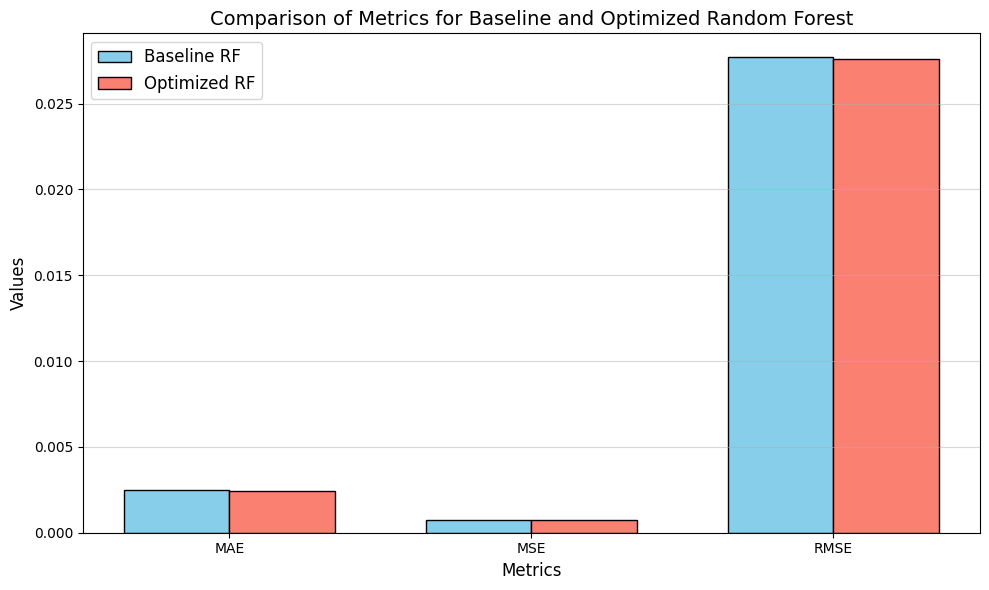

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics
metrics = ['MAE', 'MSE', 'RMSE']
baseline_values = [mae_rf, mse_rf, rmse_rf]
optimized_values = [mae_optimized, mse_optimized, rmse_optimized]

# Bar width and positions
bar_width = 0.35
index = np.arange(len(metrics))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(index, baseline_values, bar_width, label='Baseline RF', color='skyblue', edgecolor='black')
plt.bar(index + bar_width, optimized_values, bar_width, label='Optimized RF', color='salmon', edgecolor='black')

# Chart details
plt.title('Comparison of Metrics for Baseline and Optimized Random Forest', fontsize=14)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.xticks(index + bar_width / 2, metrics)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()
